In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
import zipfile
import os

zip_file_path = '/content/gdrive/MyDrive/Project_datasets/Gender_detection_dataset/archive.zip'
extract_folder = '/content/a'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"Successfully extracted contents to {extract_folder}")

Successfully extracted contents to /content/a


In [12]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend
import matplotlib.pyplot as plt

In [13]:
training_folder = '/content/a/Training'
test_folder = '/content/a/Validation'

def load_images(folder, expected_size):
    image_arrays = []
    image_label = []

    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
              img_path = os.path.join(subfolder_path, filename)

              img = load_img(img_path, target_size = expected_size)
              img_array = img_to_array(img)

              image_arrays.append(img_array)
              if subfolder == "female":
                  image_label.append([1])
              else:
                  image_label.append([0])

    return np.array(image_arrays, dtype = "float"), np.array(image_label)

In [14]:
expected_size = (28,28,3)
learning_rate = 1e-3
epochs = 100
batch_size = 32

In [15]:
X_train, y_train = load_images(training_folder,expected_size)
X_test, y_test = load_images(test_folder,expected_size)

In [16]:
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)

In [17]:
from tensorflow.keras.models import Sequential
def build(input_shape,classes):
    model = Sequential()
    chanDim = -1
    if backend.image_data_format() == "channels_first":
        height =  input_shape[0]
        width = input_shape[1]
        depth = input_shape[2]
        input_shape = (depth, height, width)
        chanDim = 1

    model.add(Conv2D(32, (3,3), padding="same", input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes, activation="sigmoid"))

    return model

In [18]:
from tensorflow.keras.losses import BinaryCrossentropy

In [19]:
model = build(expected_size, classes=2)


opt = Adam(learning_rate=learning_rate, amsgrad=False)
model.compile(loss="BinaryCrossentropy", optimizer=opt, metrics=["accuracy"])


history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/100
1470/1470 [==============================] - 14s 8ms/step - loss: 0.2969 - accuracy: 0.8874 - val_loss: 0.2616 - val_accuracy: 0.8899
Epoch 2/100
1470/1470 [==============================] - 10s 7ms/step - loss: 0.2035 - accuracy: 0.9234 - val_loss: 0.1700 - val_accuracy: 0.9312
Epoch 3/100
1470/1470 [==============================] - 10s 7ms/step - loss: 0.1840 - accuracy: 0.9319 - val_loss: 0.2689 - val_accuracy: 0.9087
Epoch 4/100
1470/1470 [==============================] - 11s 7ms/step - loss: 0.1673 - accuracy: 0.9374 - val_loss: 0.1570 - val_accuracy: 0.9406
Epoch 5/100
1470/1470 [==============================] - 10s 7ms/step - loss: 0.1603 - accuracy: 0.9420 - val_loss: 0.1340 - val_accuracy: 0.9501
Epoch 6/100
1470/1470 [==============================] - 11s 7ms/step - loss: 0.1570 - accuracy: 0.9422 - val_loss: 0.1140 - val_accuracy: 0.9577
Epoch 7/100
1470/1470 [==============================] - 10s 7ms/step - loss: 0.1546 - accuracy: 0.9447 - val_loss: 0.1233 -

In [20]:
model.save('gender_detection.model')

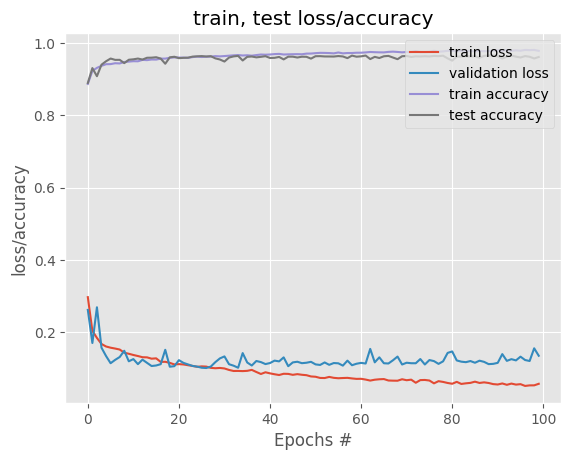

In [23]:
plt.style.use("ggplot")
plt.figure()
N=epochs
plt.plot(np.arange(0,N), history.history["loss"], label="train loss")
plt.plot(np.arange(0,N), history.history["val_loss"], label="validation loss")
plt.plot(np.arange(0,N), history.history["accuracy"], label="train accuracy")
plt.plot(np.arange(0,N), history.history["val_accuracy"], label="test accuracy")

plt.title("train, test loss/accuracy")
plt.xlabel("Epochs #")
plt.ylabel("loss/accuracy")
plt.legend(loc="upper right")

plt.savefig('loss_accuracy.png')